# Case Study 2 : Data Science in Financial Data

**Recommended Readings:** 
* [Quantopian Tutorials](https://www.quantopian.com/tutorials/) 
* Please register an account in [Quantopian online notebook system](https://www.quantopian.com/notebooks/).
* Upload this file into the system and start working on your idea.


**NOTE**
* Please download your code (notebook file as an ipynb file) and include it in your submission.


# Problem: pick a data science problem that you plan to solve using Stock Price Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data available and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [ ]:
# In order to make money off of stocks, you want to diversify your portfolio. Essentially, this means you want to invest money
# in a number of unrelated stocks, in order to decrease the risk of losing money if one of your stocks loses value. Having 
# funds invested in a number of related stocks increases the chance that all of your stocks decrease in value at the same time.

# In this section of the project, we attempt to discover correlations in the DOW 30 stocks. We compare each possible pair of 
# stocks in an attempt to find correlated stocks. The DOW 30 set of stocks is seen as a good representative for the stock
# market as a whole. If we can find correlations in these stocks, it is possible that similar algorithms may be used to find
# correlations in the stock market as a whole, leading to more thoughtful investing.

# Data Collection/Processing: 

In [26]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm 

#pulls in DOW30 stock prices back to 2000 from CSV file, drops columns with incomplete price history
data = pd.read_csv('data_monthly_5.csv')
data.drop(['V', 'DOW'], axis=1, inplace=True)
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)


#builds train and test sets
test = 36
train = data.iloc[:-test]
test = data.iloc[-test:]

#builds log returns
log = np.log(train/train.shift(1))
log = log.iloc[1:]

#builds percent returns
percent = train / train.shift(1) - 1
percent = percent.iloc[1:]

# Data Exploration: Exploring the Dataset

**plot the weekly returns of a set of stocks of your choice** 


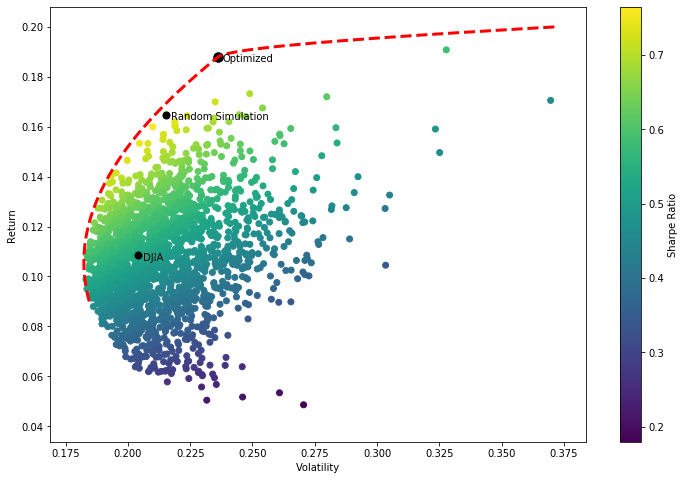

In [12]:
#plotting efficient frontier using random simulation

np.random.seed(1)
portfolios = 2000
pers = 12
positions = len(data.columns)

weights = np.zeros((portfolios, positions))
returns = np.zeros(portfolios)
volatility = np.zeros(portfolios)
sharpe = np.zeros(portfolios)

for r in range(portfolios):
    
    wgt = np.array(np.random.random(positions))
    wgt = wgt / np.sum(wgt)
    weights[r,:] = wgt
    
    returns[r] = np.sum(log.mean() * wgt * pers)
    volatility[r] = np.sqrt(np.dot(wgt.T, np.dot(log.cov() * pers, wgt)))
    sharpe[r] = returns[r] / volatility[r]

equal = np.ones(positions)
equal = equal / positions

DJIA_ret = np.sum(log.mean() * equal * pers)
DJIA_vol = np.sqrt(np.dot(equal.T, np.dot(log.cov() * pers, equal)))
DJIA_sharpe = DJIA_ret / DJIA_vol

max_sharpe_ret = returns[sharpe.argmax()]
max_sharpe_vol = volatility[sharpe.argmax()]

def metrics(wgt) :
    wgt = np.array(wgt)
    ret = np.sum(log.mean() * wgt) * pers
    vol = np.sqrt(np.dot(wgt.T, np.dot(log.cov() * pers, wgt)))
    shp = ret / vol
    return np.array([ret, vol, shp])

def n_sharpe(wgt) :
    return metrics(wgt)[2] * -1

def check(wgt) :
    return np.sum(wgt) - 1

cons = ({'type' : 'eq', 'fun' : check})
bounds = [(0,1)] * positions
guess = [1/positions] * positions

optimized = minimize(n_sharpe, guess, method = 'SLSQP', bounds = bounds, constraints = cons)
best = metrics(optimized.x)

frontier_y = np.linspace(0.09, 0.2, 200)

def minimize_vol(wgt) :
    return metrics(wgt)[1]

frontier_x = []

#### This section takes forever to run
for f in frontier_y :
    cons = ({'type' : 'eq', 'fun' : check},
            {'type' : 'eq', 'fun' : lambda w: metrics(w)[0] - f}) 
    result = minimize(minimize_vol, guess, method = 'SLSQP', bounds = bounds, constraints = cons)
    frontier_x.append(result['fun'])
########################################
    
plt.figure(figsize=(12,8))
plt.scatter(volatility, returns, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
plt.scatter(best[1], best[0],c='black', s=90)
plt.annotate('Optimized', (best[1]+.002, best[0]-.002))
plt.scatter(max_sharpe_vol, max_sharpe_ret,c='black', s=50)
plt.annotate('Random Simulation', (max_sharpe_vol+.002, max_sharpe_ret-.002))
plt.scatter(DJIA_vol, DJIA_ret,c='black', s=50)
plt.annotate('DJIA', (DJIA_vol+.002, DJIA_ret-.002))
plt.savefig('frontier.png')
plt.show()



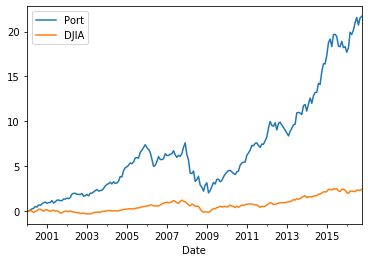

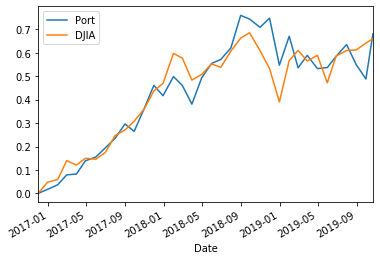

In [29]:
#plotting test
best_port = optimized.x
port_val = np.dot(test, best_port).tolist()
DJIA_val = np.dot(test, equal).tolist()
dates = np.array(test.index)

#establish training comparison
port_train = np.dot(train, best_port).tolist()
DJIA_train = np.dot(train, equal).tolist()
dates_train = np.array(train.index)

training = pd.DataFrame(dates_train, columns = ['Date'])
training['Port'] = port_train
training['DJIA'] = DJIA_train
training.set_index('Date', inplace=True)
training = training / training.iloc[0] - 1
training.plot()
plt.savefig('training.png')

testing = pd.DataFrame(dates, columns = ['Date'])
testing['Port'] = port_val
testing['DJIA'] = DJIA_val
testing.set_index('Date', inplace=True)
testing = testing / testing.iloc[0] - 1
testing.plot()
plt.savefig('testing.png')






In [37]:
#plotting correlation matrix





In [ ]:
#plotting correlations over time



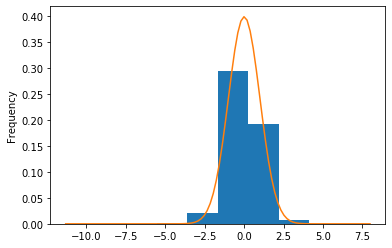

In [65]:
#plot return distribution vs gaussian
combined = []
norm_hist = percent.reset_index().drop('Date', axis=1)
for c in range(len(norm_hist.columns)) : 
    combined.append(norm_hist.iloc[:,c])
norm_hist = pd.concat(combined, ignore_index=True)
norm_hist = (norm_hist - norm_hist.mean()) / norm_hist.std()
norm_hist.plot(kind='hist', density=True)
x = np.linspace(min(norm_hist), max(norm_hist), 100)
plt.plot(x, norm.pdf(x, 0, 1))
plt.savefig('returndist.png')


In [ ]:
#plot dispersion over time
#percent.assign(max_value=percent.values.max(1))
percent['Maximum'] = percent.max(axis=1)
percent.head()

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [28]:
#demonstrate a momentum strategy in quantopian
#look for optimization packages











Write codes to implement the solution in python:

In [2]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary















# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [ ]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary









# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 2".
        
**Note: Each team only needs to submit one submission in Canvas**